In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
#from keras.layers.merge import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset_url = 'https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database?recency=last7Days'
data_dir = '/content/COVID-19_Radiography_Dataset'

In [ ]:
# #load training and testing dataset from output directory where the split is fixed for all models
# train_datagen=ImageDataGenerator(rescale = 1./255,
#                                    rotation_range=15,
#                                    fill_mode="nearest",
#                                    horizontal_flip = True)
# valid_datagen=ImageDataGenerator(rescale = 1./255)
# test_datagen=ImageDataGenerator(rescale = 1./255)

# training_set=train_datagen.flow_from_directory('/content/drive/MyDrive/New_DS/output/train',
#                                                  target_size = (224, 224),
#                                                  batch_size = 64,
#                                                  class_mode = 'categorical',
#                                                  shuffle=True)
# valid_set=valid_datagen.flow_from_directory('/content/drive/MyDrive/New_DS/output/val',
#                                             target_size = (224, 224),
#                                             batch_size = 64,
#                                             class_mode = 'categorical',
#                                             shuffle = False)
# test_set=test_datagen.flow_from_directory('/content/drive/MyDrive/New_DS/output/test',
#                                             target_size = (224, 224),
#                                             batch_size = 64,
#                                             class_mode = 'categorical',
#                                             shuffle = False)

Found 14816 images belonging to 4 classes.
Found 4233 images belonging to 4 classes.
Found 2119 images belonging to 4 classes.


In [5]:
!pip install split-folders
import splitfolders
input_folder = '/content/drive/MyDrive/Covid_DS/Covid19_Radiography Dataset'
splitfolders.ratio( input_folder,
                   output="output",seed=1337,ratio=(0.7,0.2,0.1)) 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 17606 files [05:15, 55.89 files/s] 


In [6]:
#load training and testing dataset from directory
train_datagen=ImageDataGenerator(rescale = 1./255,
                                   rotation_range=15,
                                   fill_mode="nearest",
                                   horizontal_flip = True)
valid_datagen=ImageDataGenerator(rescale = 1./255)
test_datagen=ImageDataGenerator(rescale = 1./255)

training_set=train_datagen.flow_from_directory('/content/output/train',
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical',
                                                 shuffle=True)
valid_set=valid_datagen.flow_from_directory('/content/output/val',
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical',
                                            shuffle = False)
test_set=test_datagen.flow_from_directory('/content/output/test',
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 12323 images belonging to 4 classes.
Found 3520 images belonging to 4 classes.
Found 1763 images belonging to 4 classes.


In [7]:
print(training_set.class_indices)
print(valid_set.class_indices)
print(test_set.class_indices)

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


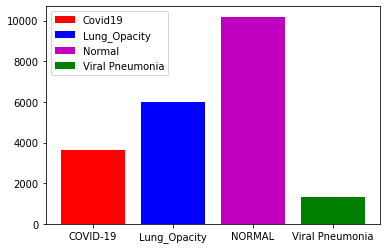

In [8]:
#visulaize data
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.bar("COVID-19",3616,color="r",label="Covid19")
ax.bar("Lung_Opacity",6012 ,color="b",label="Lung_Opacity")
ax.bar("NORMAL",10192,color="m",label="Normal")
ax.bar("Viral Pneumonia",1345,color="g",label="Viral Pneumonia")
ax.legend()

In [9]:
from tensorflow.keras.applications import DenseNet121
from keras.layers import (Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, 
                          Dense, Flatten, Dropout)
densenet = DenseNet121(
    weights=None,
    include_top=False,
    input_shape=(224,224,3)
)
DenseNet121_Model = tf.keras.models.Sequential([densenet,
                                        GlobalAveragePooling2D(),
                                        Dense(512, activation='relu'),
                                        BatchNormalization(),
                                        Dropout(0.3),
                                        Dense(4, activation='sigmoid')
                                      ])


In [10]:
DenseNet121_Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2

In [11]:
tf.keras.callbacks.ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler

In [12]:
#to avoid overfitting
early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [13]:
epochs = 100
learning_rate = 0.001
decay_rate = learning_rate / epochs
optimizer_details = Adam(lr = learning_rate, decay = decay_rate)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
DenseNet121_Model.compile(optimizer = optimizer_details, 
              loss='categorical_crossentropy',
              metrics=['accuracy','Precision','Recall'])
history = DenseNet121_Model.fit_generator(training_set, validation_data = valid_set, epochs=epochs, verbose=1, callbacks=[early])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/100
193/193 [==============================] - 227s 1s/step - loss: 0.8033 - accuracy: 0.7144 - precision: 0.4760 - recall: 0.8881 - val_loss: 2.0927 - val_accuracy: 0.2026 - val_precision: 0.2361 - val_recall: 0.5571
Epoch 2/100
193/193 [==============================] - 196s 1s/step - loss: 0.5832 - accuracy: 0.7859 - precision: 0.5001 - recall: 0.9521 - val_loss: 2.2389 - val_accuracy: 0.5855 - val_precision: 0.5342 - val_recall: 0.6952
Epoch 3/100
193/193 [==============================] - 196s 1s/step - loss: 0.4918 - accuracy: 0.8234 - precision: 0.4974 - recall: 0.9692 - val_loss: 2.0500 - val_accuracy: 0.6125 - val_precision: 0.4457 - val_recall: 0.7611
Epoch 4/100
193/193 [==============================] - 196s 1s/step - loss: 0.4539 - accuracy: 0.8367 - precision: 0.4947 - recall: 0.9726 - val_loss: 2.3459 - val_accuracy: 0.3102 - val_precision: 0.3627 - val_recall: 0.8528
Epoch 5/100
193/193 [==============================] - 196s 1s/step - loss: 0.3863 - accuracy: 0

In [15]:
DenseNet121_Model.evaluate(test_set, verbose=1)
#***model.evaluate(test_set)

28/28 [==============================] - 6s 210ms/step - loss: 3.2196 - accuracy: 0.3613 - precision: 0.3961 - recall: 0.7056


[3.219634771347046,
 0.36131593585014343,
 0.39605221152305603,
 0.7056154012680054]

In [16]:
#Accuracy, val_acc, loss, val_loss, epoch_range
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))

In [17]:
print("accuracy: ",acc)
print("validation accuracy: ",val_acc)
print("loss: ",loss)
print("validation loss: ",val_loss)
print("epochs: ",epochs)

accuracy:  [0.7143552899360657, 0.7859287261962891, 0.8234196305274963, 0.8367280960083008, 0.8618031144142151, 0.8747058510780334, 0.8788444399833679, 0.8854175209999084, 0.8962103128433228, 0.8996997475624084, 0.909031867980957, 0.9113040566444397, 0.9130082130432129, 0.9147934913635254, 0.922989547252655]
validation accuracy:  [0.2025568187236786, 0.5855113863945007, 0.612500011920929, 0.31022727489471436, 0.29431816935539246, 0.18835227191448212, 0.578125, 0.653124988079071, 0.6894886493682861, 0.7633522748947144, 0.40795454382896423, 0.20482954382896423, 0.4829545319080353, 0.5786932110786438, 0.3528409004211426]
loss:  [0.8033280372619629, 0.5831896066665649, 0.4918312132358551, 0.4538806676864624, 0.38625431060791016, 0.35467180609703064, 0.3396490812301636, 0.321827232837677, 0.28912562131881714, 0.2810557186603546, 0.2592676877975464, 0.24765416979789734, 0.24568434059619904, 0.24117380380630493, 0.22050417959690094]
validation loss:  [2.0927109718322754, 2.238867998123169, 2.

Text(0.5, 1.0, 'Training and Validation Accuracy')

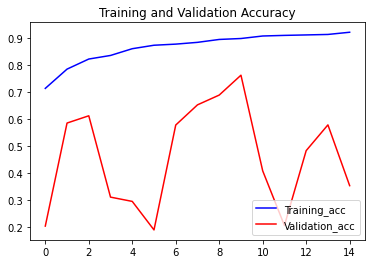

In [18]:
#plot training nad validation accuracy
plt.plot(epochs,acc,label='Training_acc',color='blue')
plt.plot(epochs,val_acc,label='Validation_acc',color='red')
plt.legend()
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation loss')

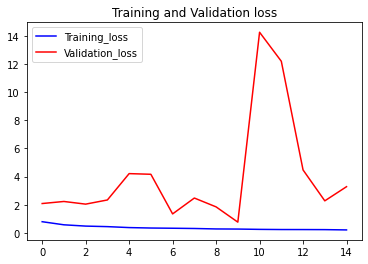

In [19]:
#training and validation loss
plt.plot(epochs,loss,label='Training_loss',color='blue')
plt.plot(epochs,val_loss,label='Validation_loss',color='red')
plt.legend()
plt.title("Training and Validation loss")

In [20]:
#model history
import pandas as pd
loss_df = pd.DataFrame(DenseNet121_Model.history.history)
loss_df

""


In [21]:
#model evaluation on testing

from keras.models import load_model

#model.load_weights("")
DenseNet121_Model.evaluate(test_set)

28/28 [==============================] - 6s 211ms/step - loss: 3.2196 - accuracy: 0.3613 - precision: 0.3961 - recall: 0.7056


[3.219634771347046,
 0.36131593585014343,
 0.39605221152305603,
 0.7056154012680054]

In [22]:
#prediction on test data
predictions = np.argmax(DenseNet121_Model.predict(test_set), axis = -1)

28/28 [==============================] - 8s 215ms/step


In [23]:
#classification report
print(classification_report(test_set.classes,predictions))

              precision    recall  f1-score   support

           0       0.81      0.57      0.67       362
           1       0.18      0.96      0.30       246
           2       0.98      0.11      0.19      1020
           3       0.94      0.62      0.75       135

    accuracy                           0.36      1763
   macro avg       0.73      0.57      0.48      1763
weighted avg       0.83      0.36      0.35      1763



In [24]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(test_set.classes, predictions)
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

[[208 154   0   0]
 [  9 236   1   0]
 [ 25 881 109   5]
 [ 14  36   1  84]]
sensitivity: 0.5746
specificity: 0.9633


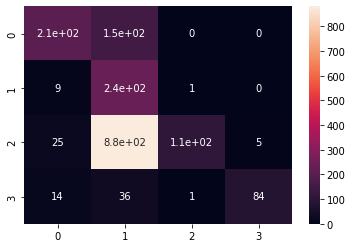

In [25]:
import seaborn as sns
print(confusion_matrix(test_set.classes,predictions))
sns.heatmap(confusion_matrix(test_set.classes,predictions), annot = True)
# show the sensitivity, and specificity
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

In [26]:
from numpy import sqrt

In [27]:
G_Mean = sqrt(sensitivity * specificity)
print("G_Mean: ", G_Mean)

G_Mean:  0.7439612946503069


In [28]:
True_Positive_Rate = cm[0, 0] / (cm[0, 0] + cm[0, 1])
False_Positive_Rate = cm[1, 0] / (cm[1, 0] + cm[1, 1])

In [29]:
print("True_Positive_Rate: {:.4f}".format(True_Positive_Rate))
print("False_Positive_Rate: {:.4f}".format(False_Positive_Rate))

True_Positive_Rate: 0.5746
False_Positive_Rate: 0.0367


# **ROC**

In [30]:
print(test_set)
print(predictions)

[1 0 0 ... 3 3 3]


In [31]:
testsetTo = np.concatenate([test_set.next()[1] for i in range(test_set.__len__())])
print(testsetTo.shape)

(1763, 4)


In [32]:
from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [33]:
#ROC-AUC Curve
# Learn to predict each class against the other
n_classes = 4 
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
thresh = dict()
roc_auc = dict()
lw = 2 
for i in range(n_classes):
    fpr[i], tpr[i], thresh[i] = roc_curve(np.argmax(testsetTo, axis=1), predictions, pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

In [34]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], thresh[i] = roc_curve(np.argmax(testsetTo, axis=1), predictions, pos_label=i) 
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # This is added back by InteractiveShellApp.init_path()


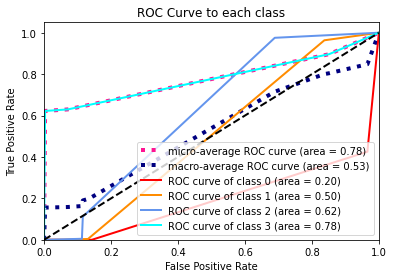

In [35]:
# Process of plotting roc-auc curve belonging to all classes.

from itertools import cycle
roc_auc_scores = []
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['red', 'darkorange', 'cornflowerblue', 'aqua'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    roc_auc_scores.append(roc_auc[i])

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve to each class')
plt.legend(loc="lower right")
plt.show()